# Assignment 1 - Image Deblurring

Name: <br>
Matriculation number:

In [24]:
import numpy as np
import scipy.sparse as sp
from PIL import Image
import matplotlib.pyplot as plt
from hessian_matrix import hessian_matrix
from scipy.sparse.linalg import inv

## Test Image

You can use the following function to create a synthetic image:



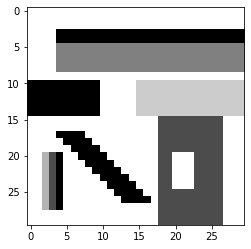

In [25]:
def create_random_binary_img_1():
    
    u = np.random.randint(1,2, 30*30).reshape(30,30).astype(float)

    u[5:9,4:] = 0.5
    u[3:5,4:] = 0
    u[10:15,:10] = 0
    u[10:15,15:] = 0.8
    u[15:, 18:27] = 0.3

    for i in range(10):
        u[i+17,i+4:i+8]  = 0
    
    u[20:25:, 20:23] = 1    
    u[20:28,4] = 0
    u[20:28,3] = 0.3
    u[20:28,2] = 0.7

    return u

sample_image = create_random_binary_img_1()

plt.imshow(sample_image, cmap ="gray")
plt.show()

## hessian_matrix() function

We provide the implementation of the hessian matrix for $k = 0, 1, 2, 3$.

input variables: 
- u: your image
- reg: regularization parameter
- k: one of the four kernel types 0-3 

Example usage:

In [26]:
u_ex = np.zeros(9).reshape(3,3)
reg_ex = 1
k_type_ex = 3
A = hessian_matrix(u_ex, reg_ex, k_type_ex)
A_n_t = A.toarray()
print(A_n_t)

[[ 4.  -2.   0.  -2.   0.   0.   0.   0.   0. ]
 [-2.   6.5 -2.   0.5 -2.   0.   0.   0.   0. ]
 [ 0.  -2.   4.5  0.   0.5 -2.   0.   0.   0. ]
 [-2.   0.5  0.   6.5 -2.   0.  -2.   0.   0. ]
 [ 0.  -2.   0.5 -2.   9.  -2.   0.5 -2.   0. ]
 [ 0.   0.  -2.   0.  -2.   6.5  0.   0.5 -2. ]
 [ 0.   0.   0.  -2.   0.5  0.   4.5 -2.   0. ]
 [ 0.   0.   0.   0.  -2.   0.5 -2.   6.5 -2. ]
 [ 0.   0.   0.   0.   0.  -2.   0.  -2.   4. ]]


## Implementation

In [105]:
def get_data_term(u, g):
    # This is the simplified version for my kernel (k1)
    # The formula can be taken from the report
    result = 0
    for x in range(u.shape[0] - 1):
        for y in range(u.shape[1] - 1):
            result += (𝑔[x, y] - 0.5 * 𝑢[x + 1, y + 1] - 0.5 * 𝑢[x, y + 1])**2
    return result

In [76]:
def get_derivative_data_term(u, g):
    """
    Given u and g, this calculates the derivative of the data term of our energy.
    The formulas are from the report and covers all 9 different cases:
    * 4 Corners
    * 4 Edges
    * Everything Else (= Pixels in the inner of the image)
    """
    m = u.shape[0] - 1
    n = u.shape[1] - 1
    result = np.zeros(u.shape)
    for x in range(u.shape[0]):
        for y in range(u.shape[1]):
            # Corners
            if x == 0 and y == 0:
                result[x,y] = 0
            elif x == 0 and y == n:
                result[x,y] = 0.5 * 𝑢[1, y] + 0.5 * 𝑢[0, y] - 𝑔[0, y - 1]
            elif x == m and y == 0:
                result[x,y] = 0
            elif x == m and y == n:
                result[x,y] = 0.5 * 𝑢[m, y] + 0.5 * 𝑢[m - 1, y] - 𝑔[m - 1, y - 1]
            # Edges
            elif x == 0:
                result[x,y] = 0.5 * 𝑢[1, y] + 0.5 * 𝑢[0, y] - 𝑔[0, y - 1]
            elif y == 0:
                result[x,y] = 0
            elif x == m:
                result[x,y] = 0.5 * 𝑢[m, y] + 0.5 * 𝑢[m - 1, y] - 𝑔[m - 1, y - 1]
            elif y == n:
                result[x,y] = 𝑢[x, n] + 0.5 * 𝑢[x - 1, n] + 0.5 * 𝑢[x + 1, n] - 𝑔[x - 1, n - 1] - 𝑔[x, n - 1]
            # Inside Image
            else:
                result[x,y] =  u[x, y] + 0.5 * u[x - 1, y] - 𝑔[x, y - 1] - 𝑔[x - 1, y - 1] + 0.5 * u[x + 1, y]
    return result

In [94]:
def get_derivative_gaussian_prior(u):
    """
    Given u, this calculates the derivative of the gaussian prior.
    The formulas are from the report and covers all 9 different cases:
    * 4 Corners
    * 4 Edges
    * Everything Else (= Pixels in the inner of the image)
    """
    m = u.shape[0] - 1
    n = u.shape[1] - 1
    result = np.zeros(u.shape)
    for x in range(u.shape[0]):
        for y in range(u.shape[1]):
            # Corners
            if x == 0 and y == 0:
                result[x,y] = 2 * (2 * 𝑢[0, 0] - 𝑢[1, 0] - 𝑢[0, 1])
            elif x == 0 and y == n:
                result[x,y] = 2 * (2 * 𝑢[0, n] - 𝑢[1, n] - 𝑢[0, n - 1])
            elif x == m and y == 0:
                result[x,y] = 2 * (2 * 𝑢[m, 0] - 𝑢[m - 1, 0] - 𝑢[m, 1])
            elif x == m and y == n:
                result[x,y] = 2 * (2 * 𝑢[m, n] - 𝑢[m - 1, n] - 𝑢[m, n - 1])
            # Edges
            elif x == 0:
                result[x,y] = 2 * (3 * 𝑢[0, y] - 𝑢[1, y] - 𝑢[0, y + 1] - 𝑢[0, y - 1])
            elif y == 0:
                result[x,y] = 2 * (3 * 𝑢[x, 0] - 𝑢[x - 1, 0] - 𝑢[x, 1] - 𝑢[x + 1, 0])
            elif x == m:
                result[x,y] = 2 * (3 * 𝑢[m, y] - 𝑢[m - 1, y] - 𝑢[m, y - 1] - 𝑢[m, y + 1])
            elif y == n:
                result[x,y] = 2 * (3 * 𝑢[x, n] - 𝑢[x, n - 1] - 𝑢[x - 1, n] - 𝑢[x + 1, n])
            # Inside Image
            else:
                result[x,y] = 2 * (4 * 𝑢[x, y] - 𝑢[x - 1, y] - 𝑢[x + 1, y] - 𝑢[x, y + 1] - 𝑢[x, y - 1])
    return result

In [75]:
def get_derivative_anisotropic_total_variation(u):
    """
    Given u, this calculates the derivative of the at variation.
    The formulas are from the report and covers all 9 different cases:
    * 4 Corners
    * 4 Edges
    * Everything Else (= Pixels in the inner of the image)
    """
    m = u.shape[0] - 1
    n = u.shape[1] - 1
    result = np.zeros(u.shape)
    for x in range(u.shape[0]):
        for y in range(u.shape[1]):
            # Corners
            if x == 0 and y == 0:
                result[x,y] = -np.𝑠𝑖𝑔𝑛(𝑢[1, 0] - 𝑢[0, 0]) - np.𝑠𝑖𝑔𝑛(𝑢[0, 1] - 𝑢[0, 0])
            elif x == 0 and y == n:
                result[x,y] = np.𝑠𝑖𝑔𝑛(𝑢[0, n] - 𝑢[0, n - 1]) - np.𝑠𝑖𝑔𝑛(𝑢[1, n] - 𝑢[0, n])
            elif x == m and y == 0:
                result[x,y] = np.𝑠𝑖𝑔𝑛(𝑢[m, 0] - 𝑢[m - 1, 0]) - np.𝑠𝑖𝑔𝑛(𝑢[m, 1] - 𝑢[m, 0])
            elif x == m and y == n:
                result[x,y] = np.𝑠𝑖𝑔𝑛(𝑢[m, n] - 𝑢[m, n - 1]) + np.𝑠𝑖𝑔𝑛(𝑢[m, n] - 𝑢[m - 1, n])
            # Edges
            elif x == 0:
                result[x,y] = -np.𝑠𝑖𝑔𝑛(𝑢[1, y] - 𝑢[0, y]) - np.𝑠𝑖𝑔𝑛(𝑢[0, y + 1] - 𝑢[0, y]) + np.𝑠𝑖𝑔𝑛(𝑢[0, y] - 𝑢[0, y - 1])
            elif y == 0:
                result[x,y] = np.𝑠𝑖𝑔𝑛(𝑢[x, 0] - 𝑢[x - 1, 0]) - np.𝑠𝑖𝑔𝑛(𝑢[x, 1] - 𝑢[x, 0]) - np.𝑠𝑖𝑔𝑛(𝑢[x + 1, 0] - 𝑢[x, 0])
            elif x == m:
                result[x,y] = np.𝑠𝑖𝑔𝑛(𝑢[m, y] - 𝑢[m - 1, y]) + np.𝑠𝑖𝑔𝑛(𝑢[m, y] - 𝑢[m, y - 1]) - np.𝑠𝑖𝑔𝑛(𝑢[m, y + 1] - 𝑢[m, y])
            elif y == n:
                result[x,y] = np.𝑠𝑖𝑔𝑛(𝑢[x, n] - 𝑢[x, n - 1]) + np.𝑠𝑖𝑔𝑛(𝑢[x, n] - 𝑢[x - 1, n]) - np.𝑠𝑖𝑔𝑛(𝑢[x + 1, n] - 𝑢[x, n])
            # Inside Image
            else:
                result[x,y] = np.sign(𝑢[x, y] - 𝑢[x - 1, y]) - np.sign(𝑢[x + 1, y] - 𝑢[x, y]) - np.sign(𝑢[x, y + 1] - 𝑢[x, y]) + np.sign(𝑢[x, y] - 𝑢[x, y - 1])
    return result

In [121]:
# TODO - we can get rid of the whole old/new stuff and just use one variable `u`
def GD(g, reg_lambda = 0.01):
    """
    Gradient Descent algorithm
    g: grayscale blurry image of size (M, N)
    reg_lambda: regularization parameter
    """
    # Exit condition: finish up, once sum of squared distances of the derivative is smaller than this number
    diff = 0.000001
    
    # Initially we start at g, but with the dimension of u
    old = np.hstack((g,np.zeros((g.shape[0], 1))))
    old = np.vstack((old, np.zeros((1, g.shape[1] + 1))))
    new = np.zeros(old.shape)
    
    """
    Choose one of these three loop conditions:
    1.) if you use No regularization
    2.) if you use Gaussian Prior
    3.) if you use AT Variation (I use a for loop, here since the exit condition does not properly converge in this scenario)
    """
    #while(np.sum(np.power(get_derivative_data_term(old, g), 2)) > diff):
    #while(np.sum(np.power(get_derivative_data_term(old, g) + reg_lambda * get_derivative_gaussian_prior(old), 2)) > diff):
    for i in range(1000):
        """
        Choose one of these three regularization parameters, this must match your selection of the loop conditions, otherwise nonesense will happen:
        1.) if you use No regularization
        2.) if you use Gaussian Prior
        3.) if you use AT Variation
        """
        # No Regularization:
        #new = old - 0.1 * (get_derivative_data_term(old, g))                  
        # Gaussian Prior:
        #new = old - 0.1 * (get_derivative_data_term(old, g) + reg_lambda * get_derivative_gaussian_prior(old))
        # AT Variation:
        new = old - 0.1 * (get_derivative_data_term(old, g) + reg_lambda * get_derivative_anisotropic_total_variation(old))
        old = new
    return new

In [92]:
def linearize(u, g, shape, reg_lambda):
    """
    Locally linearize the gradient, and then return it as a linear system.
    This works according to slide 66 of lec03-04_energy minimization.pdf
    Notice that we flatten u, s.t. we have a reasonable linear system that we can solve.
    """
    H = hessian_matrix(u.reshape(shape), reg_lambda, 1)
    A = H
    b = H * u - (get_derivative_data_term(u.reshape(shape), g) + reg_lambda * get_derivative_gaussian_prior(u.reshape(shape))).reshape(shape[0] * shape[1], 1)
    return A, b

In [98]:
def LGS(g, reg_lambda):
    """
    Linearalized Gauss Seidel Algortihm
    g: grayscale blurry image of size (M, N)
    reg_lambda: regularization parameter
    """
    # Exit condition: finish up, once sum of squared distances of the difference between current and previous u is smaller than this number
    diff = 0.00001
    
    # Initially we start at g, but with the dimension of u
    u = np.hstack((g,np.zeros((g.shape[0], 1))))
    u = np.vstack((u, np.zeros((1, g.shape[1] + 1))))
    shape = u.shape
    
    # flatten u, s.t. we can solve the linear system
    u = u.reshape(shape[0] * shape[1], 1)
    old = np.zeros(u.shape)
    
    # loop until difference is small enough
    while(np.sum(np.power(old-u, 2)) > diff):
        old = u
        # get locally linearized gradient as a linear system
        A, b = linearize(u, g, shape, reg_lambda)
        # Split A into upper and lower triangular matrix
        L = sp.tril(A, k=0)
        U = sp.triu(A, k=1)
        # Gauss-Seidel Iteration
        u = inv(L) * (b - U * u)
    return u.reshape(shape)

In [99]:
def LSOR(g, reg_lambda, w):
    """
    Linearized SOR Algorithm
    g: grayscale blurry image of size (M, N)
    reg_lambda: regularization parameter
    w: SOR parameter
    """
    # Exit condition: finish up, once sum of squared distances of the difference between current and previous u is smaller than this number
    diff = 0.00001
    
    # Initially we start at g, but with the dimension of u
    u = np.hstack((g,np.zeros((g.shape[0], 1))))
    u = np.vstack((u, np.zeros((1, g.shape[1] + 1))))
    shape = u.shape
    
    # flatten u, s.t. we can solve the linear system
    u = u.reshape(shape[0] * shape[1], 1)
    old = np.zeros(u.shape)
    
    # loop until difference is small enough
    while(np.sum(np.power(old-u, 2)) > diff):
        old = u
        # get locally linearized gradient as a linear system
        A, b = linearize(u, g, shape, reg_lambda)
        # Split A into upper, lower triangular matrix and a diagonal matrix
        U = sp.triu(A,k=1)
        L = sp.tril(A,k=-1)
        D = A - U - L
        # SOR Iteration
        u = inv(D + w*L) * (w*b - (w*U + (w-1)*D) * u)
    return u.reshape(shape)

### Parameters

In [151]:
reg_lambda = 0.005#0.0075 # AT Variation
#reg_lambda = 0.001 # Gaussian Prior
# k matrix. Look below how to choose it 
k = 1


$k =0 \longrightarrow \begin{bmatrix}\frac{1}{2} & \frac{1}{2} \\0&0\end{bmatrix} \hspace{1cm} k =1 \longrightarrow  \begin{bmatrix}\frac{1}{2} & 0 \\\frac{1}{2}&0\end{bmatrix} \hspace{1cm} k =2 \longrightarrow \begin{bmatrix}\frac{1}{2} & 0 \\0&\frac{1}{2}\end{bmatrix}   \hspace{1cm} k =3 \longrightarrow \begin{bmatrix}0 & \frac{1}{2} \\ \frac{1}{2}&0\end{bmatrix}$



# Reading image

You are provided with only the synthetic image. 
The purpose of using a synthetic image is to see possible changes in the deblurred image after applying your algorithm. 
You can convolve the original image using the [scipy library](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html).
Note that you must choose **valid** as the mode in your convolution.

In [36]:
def blur_with_kernel(image, kernel):
    result = np.zeros((image.shape[0] - 1, image.shape[1] - 1))
    for x in range(image.shape[0] - 1):
        for y in range(image.shape[1] - 1):
            for p in range(2):
                for q in range(2):
                    result[x,y] += kernel[p,q] * image[x - p + 1,y - q + 1] 
    return result

In [37]:
img_org = sample_image = create_random_binary_img_1()

# TODO: define the kernel matrix here
kernel = np.array([[0.5, 0],[0.5, 0]])

# TODO: blur this image
img_blurred = blur_with_kernel(sample_image, kernel)

## GRADIENT DESCENT

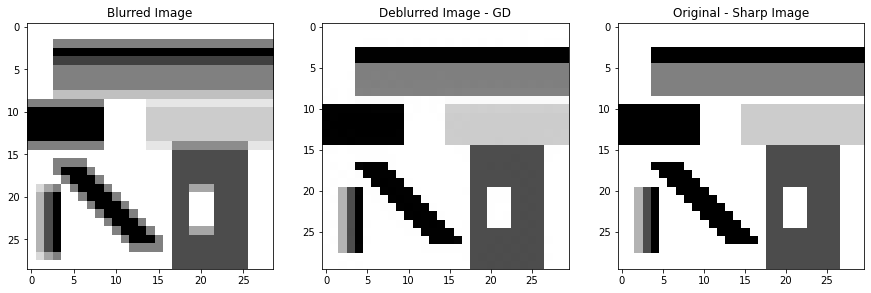

For lambda 0.00500	 
k_type 1
Loss Data Term =  0.004903251663514003
Sum of Squared Distance: deblurred vs. original =  0.016318915845570478


In [152]:
# run gradient descent algorithm
img_deblurred_gd = GD(img_blurred, reg_lambda)

# for visualization purpose 
# img_deblurred_gd = np.clip(u_final_gd, 0, 1)


plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 3, 1)
plt.imshow(img_blurred, cmap='gray')
ax2 = plt.subplot(1, 3, 2)
plt.imshow(img_deblurred_gd, cmap='gray')
ax3 = plt.subplot(1, 3, 3)
plt.imshow(img_org, cmap='gray')

ax1.set_title("Blurred Image")
ax2.set_title("Deblurred Image - GD")
ax3.set_title("Original - Sharp Image")
plt.show()

print(f"For lambda {reg_lambda:.5f}\t \nk_type {k:1d}")

# TODO: print the loss
print(f"Loss Data Term = ", get_data_term(img_deblurred_gd, img_blurred))

# TODO: print the error
print("Sum of Squared Distance: deblurred vs. original = ", np.sum(np.power(img_deblurred_gd - img_org, 2)))  

## SOR

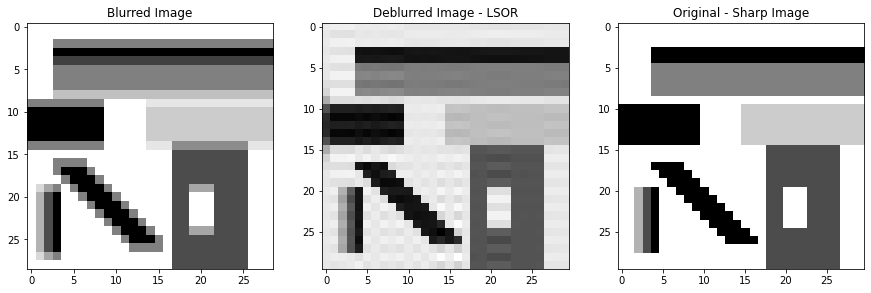

For lambda 0.00100
Loss Data Term =  0.003243886445959716
Sum of Squared Distance: deblurred vs. original =  1.1292578039273138


In [108]:
w = 1.1 #play with this

# run LSOR algorithm
img_deblurred_sor = LSOR(img_blurred, reg_lambda, w)


plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 3, 1)
plt.imshow(img_blurred, cmap='gray')
ax2 = plt.subplot(1, 3, 2)
plt.imshow(img_deblurred_sor, cmap='gray')
ax3 = plt.subplot(1, 3, 3)
plt.imshow(img_org,cmap='gray')

ax1.set_title("Blurred Image")
ax2.set_title("Deblurred Image - LSOR")
ax3.set_title("Original - Sharp Image")
#plt.savefig("results_"+str(k)+".png")
plt.show()

print(f"For lambda {reg_lambda:.5f}")

# TODO: print the loss
print(f"Loss Data Term = ", get_data_term(img_deblurred_gd, img_blurred))

# TODO: print the error
print("Sum of Squared Distance: deblurred vs. original = ", np.sum(np.power(img_deblurred_gd - img_org, 2)))  

## GAUSS - SEIDEL

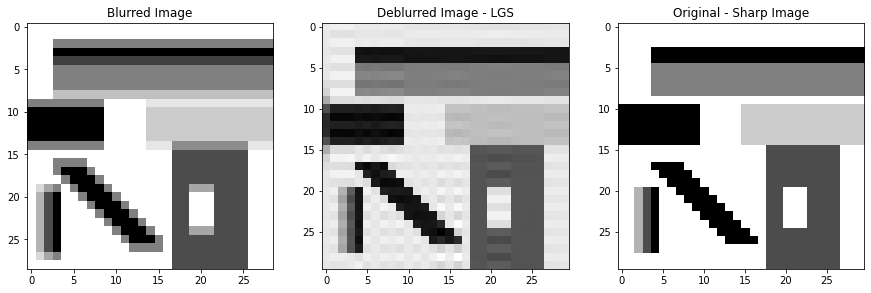

For lambda 0.00100
Loss Data Term =  0.003243886445959716
Sum of Squared Distance: deblurred vs. original =  1.1292578039273138


In [109]:
nb_iter = 1

# run LGS algorithm
img_deblurred_gs = LGS(img_blurred, reg_lambda)


plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 3, 1)
plt.imshow(img_blurred, cmap='gray')
ax2 = plt.subplot(1, 3, 2)
plt.imshow(img_deblurred_gs, cmap='gray')
ax3 = plt.subplot(1, 3, 3)
plt.imshow(img_org, cmap='gray')

ax1.set_title("Blurred Image")
ax2.set_title("Deblurred Image - LGS")
ax3.set_title("Original - Sharp Image")
plt.show()

print(f"For lambda {reg_lambda:.5f}")

# TODO: print the loss
print(f"Loss Data Term = ", get_data_term(img_deblurred_gd, img_blurred))

# TODO: print the error
print("Sum of Squared Distance: deblurred vs. original = ", np.sum(np.power(img_deblurred_gd - img_org, 2)))  